<a href="https://colab.research.google.com/github/Oshintiwari/hello-world/blob/master/pix2pix_loss_curves_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# pix2pix: Image-to-image translation with a conditional GAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to build and train a conditional generative adversarial network (cGAN) called pix2pix that learns a mapping from input images to output images, as described in [Image-to-image translation with conditional adversarial networks](https://arxiv.org/abs/1611.07004) by Isola et al. (2017). pix2pix is not application specific—it can be applied to a wide range of tasks, including synthesizing photos from label maps, generating colorized photos from black and white images, turning Google Maps photos into aerial images, and even transforming sketches into photos.

In this example, your network will generate images of building facades using the [CMP Facade Database](http://cmp.felk.cvut.cz/~tylecr1/facade/) provided by the [Center for Machine Perception](http://cmp.felk.cvut.cz/) at the [Czech Technical University in Prague](https://www.cvut.cz/). To keep it short, you will use a [preprocessed copy]((https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/)) of this dataset created by the pix2pix authors.

In the pix2pix cGAN, you condition on input images and generate corresponding output images. cGANs were first proposed in [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) (Mirza and Osindero, 2014)

The architecture of your network will contain:

- A generator with a [U-Net]([U-Net](https://arxiv.org/abs/1505.04597))-based architecture.
- A discriminator represented by a convolutional PatchGAN classifier (proposed in the [pix2pix paper](https://arxiv.org/abs/1611.07004)).

Note that each epoch can take around 15 seconds on a single V100 GPU.

Below are some examples of the output generated by the pix2pix cGAN after training for 200 epochs on the facades dataset (80k steps).

![sample output_1](https://www.tensorflow.org/images/gan/pix2pix_1.png)
![sample output_2](https://www.tensorflow.org/images/gan/pix2pix_2.png)

## Import TensorFlow and other libraries

In [2]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display
import numpy as np

## Load the dataset

Download the CMP Facade Database data (30MB). Additional datasets are available in the same format [here](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/). In Colab you can select other datasets from the drop-down menu. Note that some of the other datasets are significantly larger (`edges2handbags` is 8GB).

In [3]:
PATH_train = '/content/drive/MyDrive/pix2pix/train/'
PATH_val = '/content/drive/MyDrive/pix2pix/val/'

In [4]:
dataset_name = "facades" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]


In [5]:
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

30168306/30168306 [==============================] - 19s 1us/step


In [6]:
list(PATH.parent.iterdir())

[PosixPath('/root/.keras/datasets/facades'),
 PosixPath('/root/.keras/datasets/facades.tar.gz')]

Each original image is of size `256 x 512` containing two `256 x 256` images:

In [7]:
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


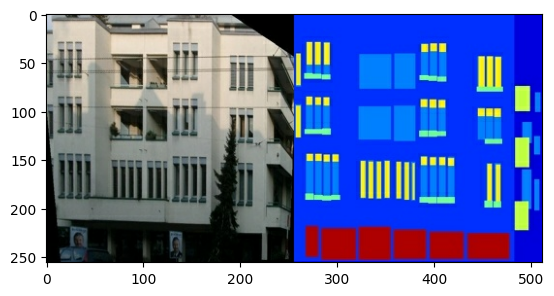

In [8]:
plt.figure()
plt.imshow(sample_image)

You need to separate real building facade images from the architecture label images—all of which will be of size `256 x 256`.

Define a function that loads image files and outputs two image tensors:

In [9]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

Plot a sample of the input (architecture label image) and real (building facade photo) images:

(256, 256, 3)


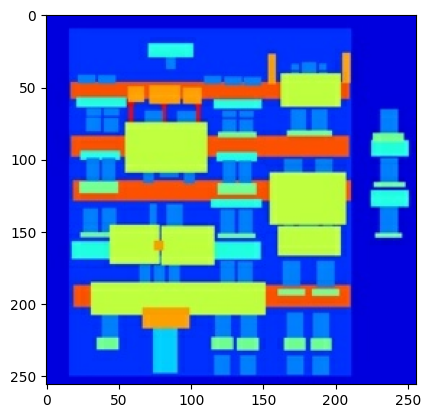

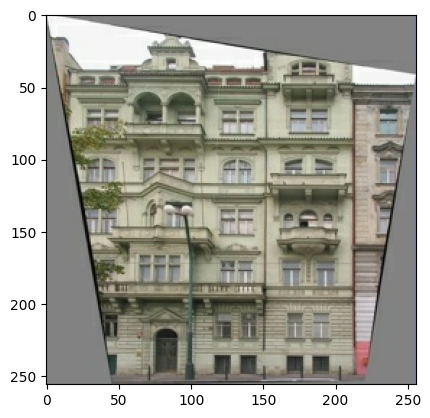

In [10]:
inp, re = load(str(PATH / 'train/100.jpg'))
print(inp.shape)
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004), you need to apply random jittering and mirroring to preprocess the training set.

Define several functions that:

1. Resize each `256 x 256` image to a larger height and width—`286 x 286`.
2. Randomly crop it back to `256 x 256`.
3. Randomly flip the image horizontally i.e. left to right (random mirroring).
4. Normalize the images to the `[-1, 1]` range.

In [11]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [12]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [13]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [14]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [15]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

You can inspect some of the preprocessed output:

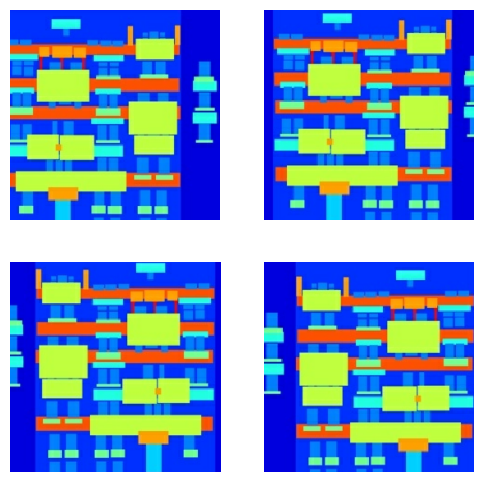

In [16]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

Having checked that the loading and preprocessing works, let's define a couple of helper functions that load and preprocess the training and test sets:

In [17]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [18]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Build an input pipeline with `tf.data`

In [19]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [20]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the generator

The generator of your pix2pix cGAN is a _modified_ [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). (You can find out more about it in the [Image segmentation](https://www.tensorflow.org/tutorials/images/segmentation) tutorial and on the [U-Net project website](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).)

- Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
- Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
- There are skip connections between the encoder and decoder (as in the U-Net).

Define the downsampler (encoder):

In [21]:
OUTPUT_CHANNELS = 3

In [22]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [23]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


Define the upsampler (decoder):

In [24]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [25]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


Define the generator with the downsampler and the upsampler:

In [26]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 10.0 MB/s eta 0:00:00


In [27]:
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [28]:
# def Generator():
#   inputs = tf.keras.layers.Input(shape=[256, 256, 3])

#   down_stack = [
#     downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
#     downsample(128, 4),  # (batch_size, 64, 64, 128)
#     downsample(256, 4),  # (batch_size, 32, 32, 256)
#     downsample(512, 4),  # (batch_size, 16, 16, 512)
#     downsample(512, 4),  # (batch_size, 8, 8, 512)
#     downsample(512, 4),  # (batch_size, 4, 4, 512)
#     downsample(512, 4),  # (batch_size, 2, 2, 512)
#     downsample(512, 4),  # (batch_size, 1, 1, 512)
#   ]

#   up_stack = [
#     upsample(512, 4, apply_dropout=False),  # (batch_size, 2, 2, 1024)
#     upsample(512, 4, apply_dropout=False),  # (batch_size, 4, 4, 1024)
#     upsample(512, 4, apply_dropout=False),  # (batch_size, 8, 8, 1024)
#     upsample(512, 4),  # (batch_size, 16, 16, 1024)
#     upsample(256, 4),  # (batch_size, 32, 32, 512)
#     upsample(128, 4),  # (batch_size, 64, 64, 256)
#     upsample(64, 4),  # (batch_size, 128, 128, 128)
#   ]

#   initializer = tf.random_normal_initializer(0., 0.02)
#   last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
#                                          strides=2,
#                                          padding='same',
#                                          kernel_initializer=initializer,
#                                          activation='tanh')  # (batch_size, 256, 256, 3)

#   x = inputs

#   # Downsampling through the model
#   skips = []
#   for down in down_stack:
#     x = down(x)
#     skips.append(x)

#   skips = reversed(skips[:-1])

#   # Upsampling and establishing the skip connections
#   for up, skip in zip(up_stack, skips):
#     x = up(x)
#     x = tf.keras.layers.Concatenate()([x, skip])

#   x = last(x)

#   return tf.keras.Model(inputs=inputs, outputs=x)

In [29]:
# def Generator_segnet(num_classes):
#     inputs = tf.keras.layers.Input(shape=[256, 256, 3])

#     # compression path
#     c1 = tf.keras.layers.Conv2D(32,(3,3), kernel_initializer = 'he_normal', padding = 'same',use_bias=False)(inputs)
#     c1 = tf.keras.layers.BatchNormalization()(c1)
#     c1 = tf.keras.layers.LeakyReLU()(c1)
#     output1, argmax1 = tf.nn.max_pool_with_argmax(c1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')

#     c2 = tf.keras.layers.Conv2D(32,(3,3), kernel_initializer = 'he_normal', padding = 'same',use_bias=False)(output1)
#     c2 = tf.keras.layers.BatchNormalization()(c2)
#     c2 = tf.keras.layers.LeakyReLU()(c2)

#     # expansion path

#     up1 = tfa.layers.MaxUnpooling2DV2(output_size=(1, 256,256,32))(c2, argmax1)
#     c5 = tf.keras.layers.Conv2D(32,(3,3),kernel_initializer='he_normal',padding='same',use_bias=False)(up1)
#     c5 = tf.keras.layers.BatchNormalization()(c5)
#     #c5 = tf.keras.layers.Dropout(0.5)(c5)
#     c5 = tf.keras.layers.LeakyReLU()(c5)
#     c5 = tf.keras.layers.Conv2D(OUTPUT_CHANNELS,(3,3), activation = 'tanh', kernel_initializer = 'he_normal', padding = 'same')(c5)

#     return tf.keras.Model(inputs=inputs, outputs=c5)


In [30]:
# def Generator_segnet(num_classes):
#     inputs = tf.keras.layers.Input(shape=[256, 256, 3])

#     # compression path
#     c1 = tf.keras.layers.Conv2D(32,(3,3), kernel_initializer = 'he_normal', padding = 'same',use_bias=False , activation = 'relu')(inputs)
#     c1 = tf.keras.layers.BatchNormalization()(c1)
#     c1 = tf.keras.layers.LeakyReLU()(c1)
#     output1, argmax1 = tf.nn.max_pool_with_argmax(c1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')

#     c3 = tf.keras.layers.Conv2D(32,(3,3), kernel_initializer = 'he_normal', padding = 'same',use_bias=False , activation = 'relu')(output1)
#     c3 = tf.keras.layers.BatchNormalization()(c3)
#     c3 = tf.keras.layers.LeakyReLU()(c3)
#     output2, argmax2 = tf.nn.max_pool_with_argmax(c3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')

#     c2 = tf.keras.layers.Conv2D(32,(3,3), kernel_initializer = 'he_normal', padding = 'same',use_bias=False , activation = 'relu')(output2)
#     c2 = tf.keras.layers.BatchNormalization()(c2)
#     c2 = tf.keras.layers.LeakyReLU()(c2)

#     # expansion path

#     up1 = tfa.layers.MaxUnpooling2DV2(output_size=(1,128,128,32))(c2, argmax2)
#     c6 = tf.keras.layers.Conv2D(32,(3,3),kernel_initializer='he_normal',padding='same',use_bias=False , activation = 'relu')(up1)
#     c6 = tf.keras.layers.Conv2D(32,(3,3),kernel_initializer='he_normal',padding='same',use_bias=False , activation = 'relu')(c6)

#     up2 = tfa.layers.MaxUnpooling2DV2(output_size=(1,256,256,32))(c6, argmax1)
#     c5 = tf.keras.layers.Conv2D(32,(3,3),kernel_initializer='he_normal',padding='same',use_bias=False , activation = 'relu')(up2)
#     c5 = tf.keras.layers.Conv2D(32,(3,3),kernel_initializer='he_normal',padding='same',use_bias=False , activation = 'relu')(c5)

#     c5 = tf.keras.layers.BatchNormalization()(c5)
#     c5 = tf.keras.layers.Dropout(0.5)(c5)
#     c5 = tf.keras.layers.LeakyReLU()(c5)
#     c5 = tf.keras.layers.Conv2D(OUTPUT_CHANNELS,(3,3), activation = 'tanh', kernel_initializer = 'he_normal', padding = 'same')(c5)

#     return tf.keras.Model(inputs=inputs, outputs=c5)


Generator model increases and decreases image size.
1. Why do we need to increase and decrease?


In [31]:
def Generator_segnet(num_classes):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # compression path
    c1 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer= 'he_normal', padding='same', use_bias=False, activation='relu')(inputs)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.LeakyReLU()(c1)
    output1, argmax1 = tf.nn.max_pool_with_argmax(c1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')

    c2 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(output1)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.LeakyReLU()(c2)
    output2, argmax2 = tf.nn.max_pool_with_argmax(c2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool2')

    c3 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(output2)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = tf.keras.layers.LeakyReLU()(c3)
    output3, argmax3 = tf.nn.max_pool_with_argmax(c3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool3')

    c4 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(output3)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    c4 = tf.keras.layers.LeakyReLU()(c4)
    output4, argmax4 = tf.nn.max_pool_with_argmax(c4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool4')

    c5 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(output4)
    c5 = tf.keras.layers.BatchNormalization()(c5)
    c5 = tf.keras.layers.LeakyReLU()(c5)
    output5, argmax5 = tf.nn.max_pool_with_argmax(c5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool5')

    c6 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(output5)
    c6 = tf.keras.layers.BatchNormalization()(c6)
    c6 = tf.keras.layers.LeakyReLU()(c6)
    output6, argmax6 = tf.nn.max_pool_with_argmax(c6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool6')

    c7 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(output6)
    c7 = tf.keras.layers.BatchNormalization()(c7)
    c7 = tf.keras.layers.LeakyReLU()(c7)
    output7, argmax7 = tf.nn.max_pool_with_argmax(c7, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool7')

    c8 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(output7)
    c8 = tf.keras.layers.BatchNormalization()(c8)
    c8 = tf.keras.layers.LeakyReLU()(c8)
    output8, argmax8 = tf.nn.max_pool_with_argmax(c8, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool8')

    # expansion path
    up1 = tfa.layers.MaxUnpooling2DV2(output_size=(1, 2, 2, 32))(output8, argmax8)
    u8 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(up1)
    u8 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(u8)
    # u8 = tf.keras.layers.BatchNormalization()(u8)

    up2 = tfa.layers.MaxUnpooling2DV2(output_size=(1, 4, 4, 32))(u8, argmax7)
    u7 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(up2)
    u7 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(u7)

    up3 = tfa.layers.MaxUnpooling2DV2(output_size=(1, 8, 8, 32))(u7, argmax6)
    u6 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(up3)
    u6 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(u6)

    up4 = tfa.layers.MaxUnpooling2DV2(output_size=(1, 16, 16, 32))(u6, argmax5)
    u5 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(up4)
    u5 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(u5)

    up5 = tfa.layers.MaxUnpooling2DV2(output_size=(1, 32, 32, 32))(u5, argmax4)
    u4 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(up5)
    u4 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(u4)

    up6 = tfa.layers.MaxUnpooling2DV2(output_size=(1, 64, 64, 32))(u4, argmax3)
    u3 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(up6)
    u3 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(u3)

    up7 = tfa.layers.MaxUnpooling2DV2(output_size=(1, 128, 128, 32))(u3, argmax2)
    u2 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(up7)
    u2 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(u2)

    up8 = tfa.layers.MaxUnpooling2DV2(output_size=(1, 256, 256, 32))(u2, argmax1)
    u1 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(up8)
    u1 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False, activation='relu')(u1)

    c9 = tf.keras.layers.BatchNormalization()(u1)
    c9 = tf.keras.layers.Dropout(0.5)(c9)
    c9 = tf.keras.layers.LeakyReLU()(c9)
    c9 = tf.keras.layers.Conv2D(num_classes, (3, 3), activation='linear', kernel_initializer='he_normal', padding='same')(c9)

    return tf.keras.Model(inputs=inputs, outputs=c9)


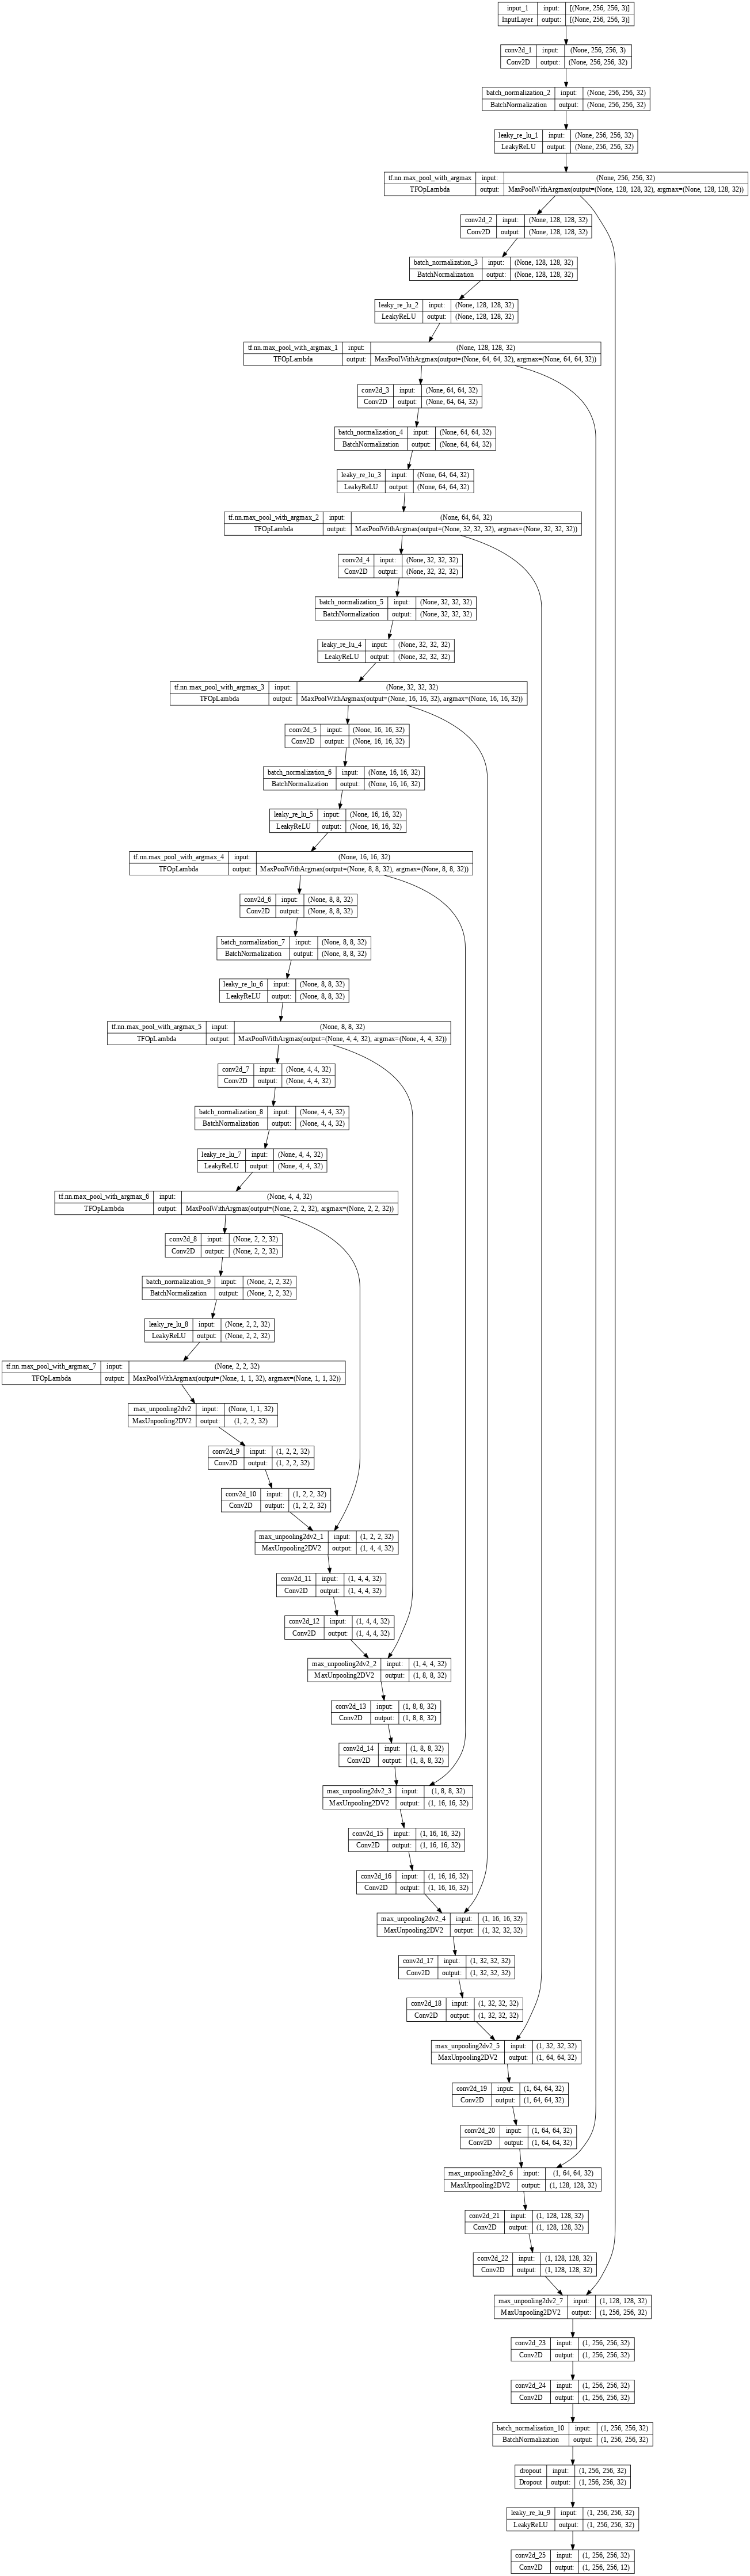

In [32]:
generator = Generator_segnet(12)
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

One-Hot -> RGB

(1, 256, 256, 12)
(256, 256, 12)


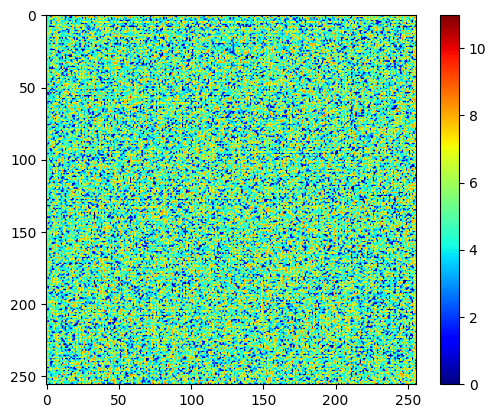

In [76]:
out = generator(inp[tf.newaxis, ...], training=False) # out is one-hot coded, 12 classes

out.shape
print(out.shape)
out_new = out[0,:,:,:]

out_new = tf.nn.softmax(out_new,axis=2) #normalize

# out_new = tf.cast(out_new > 0.5, tf.float32) #thresholding/to 0.5

out_new = tf.convert_to_tensor(out_new.numpy(), dtype=tf.float32)
print(out_new.shape)
out_indexed = np.zeros((256,256))


# for i in range(12):
#   out_indexed += 1*out_new[:,:,i]

# choose the class with the highest probability at each pixel location
out_indexed = np.argmax(out_new, axis=2) # array where each pixel contains the index of the class with the highest probability.

plt.imshow(out_indexed,cmap='jet')
plt.colorbar()
plt.show()

In [77]:
# gen_output = generator(inp[tf.newaxis, ...], training=False)
# plt.imshow(gen_output[0, ...])

In [78]:
tf.nn.softmax(tf.constant([.3,.2,2],dtype='float32'))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.13552366, 0.1226269 , 0.7418494 ], dtype=float32)>

In [79]:
 def poolUnpool():
    inputs = tf.keras.layers.Input(shape=[2, 2, 1])  # Update input shape to include the channel dimension

    # Compression path
    p1, a1 = tf.nn.max_pool_with_argmax(inputs, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')
    u1 = tfa.layers.MaxUnpooling2D()(p1, a1)

    return tf.keras.Model(inputs=inputs, outputs=u1)

net = poolUnpool() #creating an instance of the function poolUnpool()

# Simple test case
x = tf.constant([[[[1], [2]], [[23], [42]]]], dtype=tf.float32)  # input tensor with shape (1,2,2,1)
y = net(x)
print(y)


tf.Tensor(
[[[[ 0.]
   [ 0.]]

  [[ 0.]
   [42.]]]], shape=(1, 2, 2, 1), dtype=float32)


In [80]:
def poolUnpool():
    inputs = tf.keras.layers.Input(shape=[4,4, 1])  # Update input shape to include the channel dimension

    # Compression path
    p1, a1 = tf.nn.max_pool_with_argmax(inputs, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')
    u1 = tfa.layers.MaxUnpooling2D()(p1, a1)

    return tf.keras.Model(inputs=inputs, outputs=u1)

net = poolUnpool() #creating an instance of the function poolUnpool()

# Simple test case

x = tf.constant([[[[1], [2], [3], [4]],
                  [[5], [6], [7], [8]],
                  [[9], [10], [11], [12]],
                  [[13], [14], [15], [16]]]], dtype=tf.float32)  # input tensor with shape (1,4,4,1)
y = net(x)
print(y)

tf.Tensor(
[[[[ 0.]
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 6.]
   [ 0.]
   [ 8.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [14.]
   [ 0.]
   [16.]]]], shape=(1, 4, 4, 1), dtype=float32)


 All non-maximal values are set to zero

The default behavior of ' tfa.layers.MaxUnpooling2D() ' layer is not correctly restoring the original values.

TensorFlow does not provide a built-in MaxUnpooling2D layer.

Performing max pooling and unpooling using the torch.nn.MaxPool2d and torch.nn.MaxUnpool2d modules in PyTorch:

In [81]:
#3: pool-unpool-conv-relu-conv-tanh simple net
def poolUnpoolConvConv():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Compression path
    p1, a1 = tf.nn.max_pool_with_argmax(inputs, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')

    # expand
    u1 = tfa.layers.MaxUnpooling2D()(p1, a1)

    u2 = tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='relu')(u1)
    u3 = tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh')(u2)
    # conv2d
    #relu
    #conv2d
    # tanh

    return tf.keras.Model(inputs=inputs, outputs=u3)

# net = poolUnpool()

In [82]:
#4: try poolUnpoolConvConv() in photo-to-photo reconstruction

Used MaxUnpooling2D instead of 2DV2

Visualize the generator model architecture:

Test the generator:

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [83]:
LAMBDA = 100

In [84]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [85]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + 0*(LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs:
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

Let's define the discriminator:

In [86]:
def Discriminator(classes):
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 12], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(classes, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size), 30, 30, 12)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

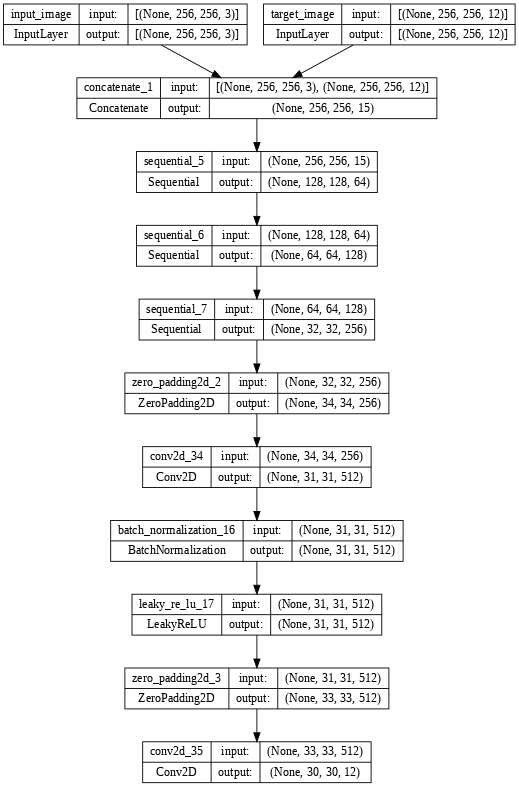

In [87]:
discriminator = Discriminator(12)
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Test the discriminator:

out_disc shape : --> (1, 30, 30, 12)
out_disc shape : --> (30, 30, 12)


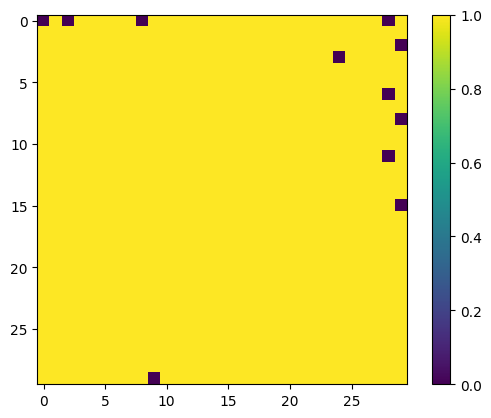

In [88]:
out_disc = discriminator([inp[tf.newaxis, ...], out], training=False) # out is one-hot coded, 12 classes

out_new_disc = out_disc[0,:,:,:]
print("out_disc shape : -->", out_disc.shape)
print("out_disc shape : -->", out_new_disc.shape)

out_new_disc = tf.nn.softmax(out_new_disc) #normalize

out_new_disc = tf.cast(out_new_disc > 0.5, tf.float32) #thresholding to 0.5
out_new_disc = tf.convert_to_tensor(out_new_disc.numpy(), dtype=tf.float32)

out_indexed_disc = np.zeros((30,30))

for i in range(12):
  out_indexed_disc += 1*out_new_disc[:,:,i]

plt.imshow(out_indexed_disc)
plt.colorbar()

In [89]:
out_disc.shape

TensorShape([1, 30, 30, 12])

(1, 256, 256, 12)


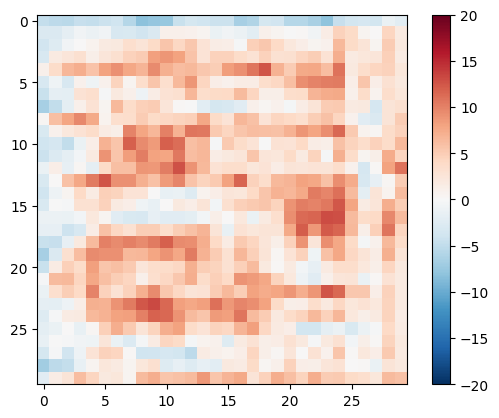

In [91]:
out_reshaped = tf.reshape(out,[1,256,256,12]) #[None, 256,256,12]
print(out_reshaped.shape)

disc_out = discriminator([inp[tf.newaxis, ...], out_reshaped], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### Define the discriminator loss

- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [47]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the optimizers and a checkpoint-saver


In [48]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [49]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and _voila_!

Note: The `training=True` is intentional here since
you want the batch statistics, while running the model on the test dataset. If you use `training=False`, you get the accumulated statistics learned from the training dataset (which you don't want).

In [50]:
%matplotlib inline

def generate_images(model, test_input, tar):

    prediction = generator(example_input, training=True)
    print("Ex_inp-->",example_input[0,:,:,:].shape, "Ex_tar-->",example_target.shape)
    plt.figure(figsize=(15, 15))

    plt.subplot(1, 3, 1)
    plt.imshow(example_input[0, :, :, :])
    plt.title("Example input")

    plt.subplot(1, 3, 2)
    plt.imshow(example_target[0, :, :, :])
    plt.title("Example target")

    # Create a combined visualization of all 12 channels
    combined_prediction = np.zeros((256, 256))  # Initialize with zeros

    for i in range(12):
        combined_prediction += prediction[0, :, :, i]
    print("Prediction-->",prediction.shape)
    plt.subplot(1, 3, 3)
    plt.imshow(combined_prediction)
    plt.title("Combined Prediction Image")

    plt.show()


Test the function:

Ex_inp--> (256, 256, 3) Ex_tar--> (1, 256, 256, 3)
Prediction--> (1, 256, 256, 12)


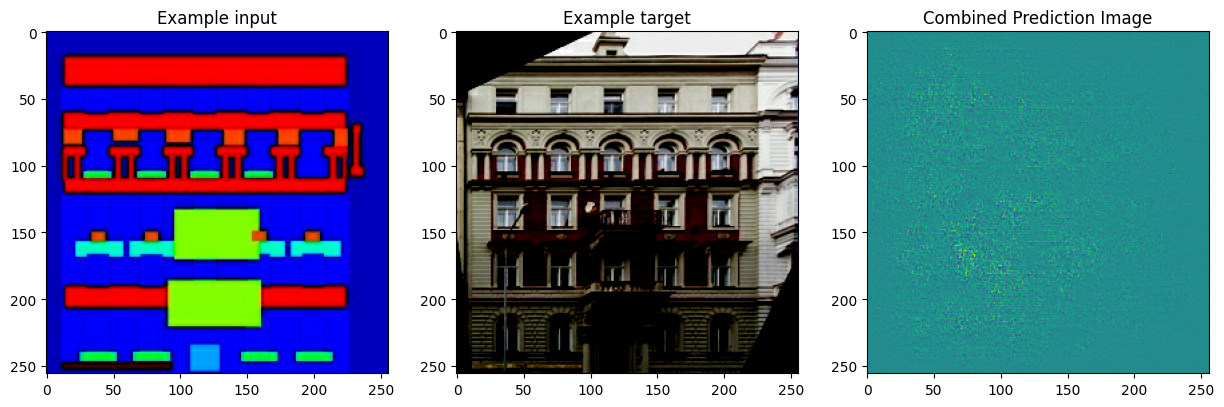

In [51]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [52]:
# def generate_images(model, test_input, tar):
#   prediction = model(test_input, training=True)
#   plt.figure(figsize=(15, 15))

#   display_list = [test_input[0], tar[0], prediction[0]]
#   title = ['Input Image', 'Ground Truth', 'Predicted Image']

#   for i in range(3):
#     plt.subplot(1, 3, i+1)
#     plt.title(title[i])
#     # Getting the pixel values in the [0, 1] range to plot.
#     plt.imshow(display_list[i] * 0.5 + 0.5)
#     plt.axis('off')
# # Make a colorbar for the ContourSet returned by the contourf call.
#   plt.show()




## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

In [53]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [54]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    # disc_real_output = discriminator([input_image, target], training=True)
    # disc_generated_output = discriminator([input_image, gen_output], training=True)

    # gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    gen_total_loss = loss_object(gen_output,target)
    # disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  # discriminator_gradients = disc_tape.gradient(disc_loss,
  #                                              discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  # discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
  #                                             discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    # tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    # tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    # tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

  return gen_total_loss


In [55]:
@tf.function
def test_step(input_image, target, step):
  gen_output = generator(input_image, training=True)
  disc_real_output = discriminator([input_image, target], training=True)
  disc_generated_output = discriminator([input_image, gen_output], training=True)

  gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
  disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

  return gen_l1_loss


The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [56]:
import numpy as np

# Fit for train loss

In [57]:
def fit_train(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  history_l1_train = np.zeros(steps)

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    l1_train = train_step(input_image, target, step)
    history_l1_train[step] = l1_train

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
  np.save("history_l1_train.npy",history_l1_train)
  # np.save("history_l1_train.npy",history_l1_test)
#     return history_l1_train


# Fit for test loss

In [58]:
def fit_test(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  history_l1_test = np.zeros(steps)

  for step, (input_image, target) in test_ds.repeat().take(steps).enumerate():
#   for step, (input_image, target), (input_test, target_test) in zip( train.ds.repeat().take(steps).enumerate() test.ds.repeat().take(steps).enumerate()):
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    l1_test = train_step(input_image, target, step)
    history_l1_test[step] = l1_test


    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
  np.save("history_l1_test.npy",history_l1_test)
#     return history_l1_train

# Fit for train and test loss

In [59]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  history_l1_train = np.zeros(steps)
  history_l1_test = np.zeros(steps)

  for (step,(input_train, target_train)),(step2,(input_test, target_test)) in zip(train_ds.repeat().take(steps).enumerate(), test_ds.repeat().take(steps).enumerate()):
  #for step,input_train, target_train in train_ds.repeat().take(steps).enumerate():

    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      # generate_images(generator, example_target, example_input)
      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    l1_train = train_step(input_train, target_train, step)
    # l1_train = train_step(target_train, target_train, step)
    history_l1_train[step] = l1_train

    l1_test = test_step(input_test, target_test, step)
    # l1_test = test_step(target_test, target_test, step)
    history_l1_test[step] = l1_test

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

  # Save the training history arrays
  np.save("history_l1_train.npy",history_l1_train)
  np.save("history_l1_test.npy",history_l1_test)


# fit(train_dataset, test_dataset, steps=100)


This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

To launch the viewer paste the following into a code-cell:

In [60]:
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

Finally, run the training loop:

Ex_inp--> (256, 256, 3) Ex_tar--> (1, 256, 256, 3)
Prediction--> (1, 256, 256, 12)


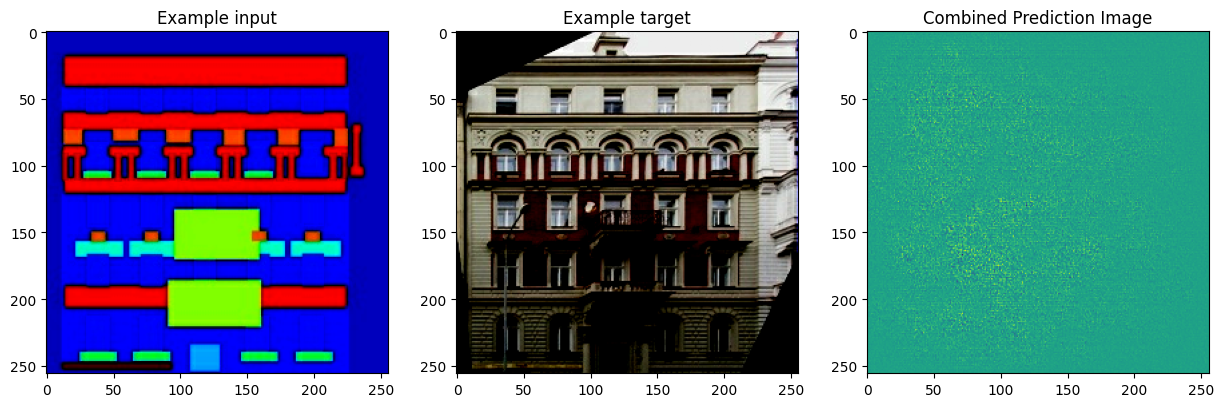

Step: 0k


ValueError: ignored

In [61]:
fit(train_dataset, test_dataset, steps=40000)

# history_l1_train

In [ ]:
history_l1_train = np.load('history_l1_train.npy')
plt.plot(history_l1_train)
plt.show()

In [ ]:
history_l1_train

In [ ]:
# Define the filter order and cutoff frequency
order = 4
cutoff = 0.2

In [ ]:
 history_l1_test = np.load('history_l1_test.npy')
plt.plot(history_l1_test)

In [ ]:
from scipy.signal import savgol_filter, filtfilt

In [ ]:
# Apply a Savitzky-Golay filter with a window size of 3 and a polynomial order of 2
y_smooth1 = savgol_filter(history_l1_train, window_length=40000, polyorder=2)
y_smooth2 = savgol_filter(history_l1_test, window_length=40000, polyorder=2)

plt.plot(y_smooth1, label='train l1 loss')
plt.plot(y_smooth2, label='test l1 loss')
plt.grid()
plt.xlabel("Steps")
plt.legend()
plt.show()

In [ ]:
# %load_ext tensorboard
%reload_ext tensorboard
# %tensorboard --logdir {log_file_path}

If you want to share the TensorBoard results _publicly_, you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This requires a Google account.

```
!tensorboard dev upload --logdir {log_dir}
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It can also included inline using an `<iframe>`:

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)